In [2]:
import json, statistics
import pandas as pd
import os, math
import matplotlib.pyplot as plt

In [30]:
%matplotlib inline
from IPython.display import SVG, HTML
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

output_path = '../assets/'

def to_list(data, _type='E_outs'):
    return [i['avg'] for i in data[_type]]
def to_upper_stdev(data, _type='E_outs'):
    return [i['avg']+i['stdev'] for i in data[_type]]
def to_lower_stdev(data, _type='E_outs'):
    return [i['avg']-i['stdev'] for i in data[_type]]

def format_err_ax(pl):
    vals = pl.get_yticks()
    pl.set_yticklabels(['{:.0f}%'.format(x*100) for x in vals])
    pl.set_ylabel('Error Rate', fontsize=14)

def format_plot(pl):
    pl.grid('on', which='major', axis='x', linestyle=':')
    pl.grid('on', which='major', axis='y', linestyle=':')
    pl.legend(frameon=False, fontsize=14)
    pl.spines['top'].set_visible(False)
    pl.spines['right'].set_visible(False)
    plt.tight_layout()

def sort_cols_by_insertion_order(data_dict, df):
    column_order = list(data_dict.keys())  # python 3.6 keeps dicts ordered by insertion sequence
    return df.reindex_axis(column_order, axis=1)

def line_w_error(lines, plot_path=output_path, error=True, alpha=.2, fill_na=False, name='',
                ylim=None, xlim=None, baselines=None, xlabel=None, ylabel=None, _type='E_outs'):
    transformed = {name: to_list(values, _type=_type) for name, values in lines.items()}
    max_num_of_vals = max([len(i) for i in transformed.values()])
    min_num_of_vals = min([len(i) for i in transformed.values()])
    if fill_na:
        transformed = {k: v + [None]*(max_num_of_vals-len(v)) for k, v in transformed.items()}
        plot_min = max_num_of_vals
    else:
        plot_min = min_num_of_vals
    df = pd.DataFrame({k: v[:plot_min] for k, v in transformed.items()})
    df = sort_cols_by_insertion_order(lines, df)
    pl = df.plot(kind="line", legend=True, grid=True, fontsize=14, ylim=ylim, xlim=xlim)
    if error:
        for values in lines.values():
            non_none_len = len([i for i in values[_type] if i is not None])
            pl.fill_between(range(non_none_len), to_lower_stdev(values), to_upper_stdev(values), alpha=alpha)

    if baselines is not None:
        for bname, val in baselines.items():
            pl.plot([0,  max_num_of_vals], [val, val], color='g', linestyle=':')
            ax_rel_pos = pl.get_position()
            ax_x, ax_y = pl.transAxes.transform((ax_rel_pos.x0, ax_rel_pos.y0))
            x, y = pl.transData.transform((0, val))
            pl.annotate(bname, (ax_x-20, y+5), xycoords='figure pixels',  color='g')

    pl.set_xlabel('Labeled Instances', fontsize=14)
    format_err_ax(pl)
    format_plot(pl)
    pl.get_figure().savefig(os.path.join(plot_path, name + '_plot.pdf'), format='pdf')

def bars_w_err(bars, index, plot_path=output_path, error=True, alpha=.2, fill_na=False, reverseColumns=False, name='',
                ylim=None, xlim=None, baseline=None, xlabel=None, ylabel=None, _type='E_outs'):
    transformed_raw = {name: [to_list(vals, _type=_type) for vals in raw_vals] for name, raw_vals in bars.items()}
    transformed = {name: [sum(v)/len(v) for v in vals] for name, vals in transformed_raw.items()}

    df = pd.DataFrame(transformed, index=index)
    if reverseColumns:
        df = df.reindex_axis(reversed(df.columns), axis=1)
    if error:
        stdevs = {name: [statistics.stdev(v) for v in vals] for name, vals in transformed_raw.items()}
    else:
        stdevs = None
    print(df)
    pl = df.plot(kind="bar", rot=0, grid=True, fontsize=14, yerr=stdevs, ylim=ylim, xlim=xlim, alpha=.5, capsize=3)
    pl.grid(b=False, which='major', axis='x', )
    pl.set_ylabel('Duration (seconds)', fontsize=14)
    
    format_plot(pl)
    pl.get_figure().savefig(os.path.join(plot_path,name + '_plot.pdf'), format='pdf')
    


## Training duration

       Training Duration
1               0.350094
10              0.440772
100             1.031119
1000           10.929628
10000         230.123516


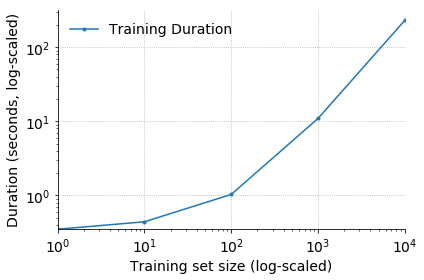

In [4]:
path = '../results/'
with open(path + 'training_time_results.json') as f:
    m = json.load(f)['results']
x = [int(i) for i in m.keys()]
y = [i['avg'] for i in m.values()]

df = pd.DataFrame({'Training Duration': y}, index=x)
print(df.head())
pl = df.plot(loglog=True, style='.-', fontsize=14, ylim=(0,None))
format_plot(pl)
pl.set_ylabel('Duration (seconds, log-scaled)', fontsize=14)
pl.set_xlabel('Training set size (log-scaled)', fontsize=14)
plt.tight_layout()
pl.get_figure().savefig(os.path.join(output_path,'train_duration.pdf'), format='pdf')

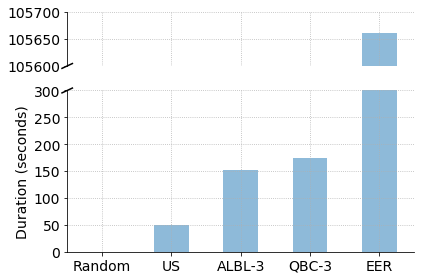

In [5]:
path = '../results/duration_strategies/'
with open(path + 'albl_results.json') as f:
    albl = json.load(f)
with open(path + 'qbc_KL_results.json') as f:
    qbc = json.load(f)
with open(path + '../durations_of_us_versions/query_only/entropy/us_ENTROPY_results.json') as f:
    us = json.load(f)
with open(path + 'random_results.json') as f:
    rnd = json.load(f)

stdevs = {'ALBL-3': albl['durations'][0]['stdev'], 'QBC-3': qbc['durations'][0]['stdev'], 'EER': 0,
         'US': us['durations'][0]['stdev'], 'Random': rnd['durations'][0]['stdev']}

d = {
    'Random': rnd['durations'][0]['avg'],
    'US': us['durations'][0]['avg'],
    'ALBL-3': albl['durations'][0]['avg'],
    'QBC-3': qbc['durations'][0]['avg'],
    'EER': 105660
}
df = pd.DataFrame(list(d.values()), index=d.keys())
# df = sort_cols_by_insertion_order(d, df)

from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
axis = (plt.subplot(gs[0]), plt.subplot(gs[1]))

# f, axis = plt.subplots(2, 1, sharex=True)
pl1 = df.plot(kind='bar', ax=axis[0], rot=0, grid=True, fontsize=14, yerr=stdevs, alpha=.5, capsize=3)
pl2 = df.plot(kind='bar', ax=axis[1], rot=0, grid=True, fontsize=14, yerr=stdevs, alpha=.5, capsize=3)
axis[1].set_ylim(0, 300)
axis[0].set_ylim(105600, 105700)

axis[0].spines['bottom'].set_visible(False)
axis[1].spines['top'].set_visible(False)

d = .015

kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
axis[0].plot((-d,+d),(-d-0.035,+d+.025), **kwargs)
kwargs.update(transform=axis[1].transAxes)
axis[1].plot((-d,+d),(1-d,1+d), **kwargs)

axis[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

format_plot(pl1)
format_plot(pl2)
axis[0].legend().set_visible(False)
axis[1].legend().set_visible(False)
pl2.set_ylabel('Duration (seconds)', fontsize=14)
plt.savefig(os.path.join(output_path,'iteration_duration_plot.pdf'), format='pdf')

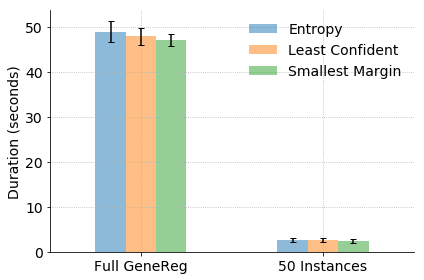

In [6]:
path = '../results/durations_of_us_versions/'
with open(path + 'query_only/sm/us_SM_results.json') as f:
    u_sm = json.load(f)
with open(path + 'query_only/lc/us_LC_results.json') as f:
    u_lc = json.load(f)
with open(path + 'query_only/entropy/us_ENTROPY_results.json') as f:
    u_ent = json.load(f)

with open(path + 'query_only-50/us_SM_results.json') as f:
    u_sm_50 = json.load(f)
with open(path + 'query_only-50/us_LC_results.json') as f:
    u_lc_50 = json.load(f)
with open(path + 'query_only-50/us_ENTROPY_results.json') as f:
    u_ent_50 = json.load(f)

stdevs = {
    'Entropy': [u_ent['durations'][0]['stdev'], u_ent_50['durations'][0]['stdev']],
    'Smallest Margin': [u_sm['durations'][0]['stdev'], u_sm_50['durations'][0]['stdev']],
    'Least Confident': [u_lc['durations'][0]['stdev'], u_lc_50['durations'][0]['stdev']],
}
d = {
    'Entropy': [u_ent['durations'][0]['avg'], u_ent_50['durations'][0]['avg']],
    'Smallest Margin': [u_sm['durations'][0]['avg'], u_sm_50['durations'][0]['avg']],
    'Least Confident': [u_lc['durations'][0]['avg'], u_lc_50['durations'][0]['avg']]
}

df = pd.DataFrame(d, index=['Full GeneReg', '50 Instances'])
pl = df.plot(kind='bar', rot=0, grid=True, fontsize=14, yerr=stdevs, alpha=.5, capsize=3)
pl.set_ylabel('Duration (seconds)', fontsize=14)
format_plot(pl)
plt.savefig(os.path.join(output_path,'us_duration_plot.pdf'), format='pdf')

## Final datasets

* base: GeneReg
* poolsize: 1174
* test size: 1000
* 500 iterations
* 5 runs per strategy

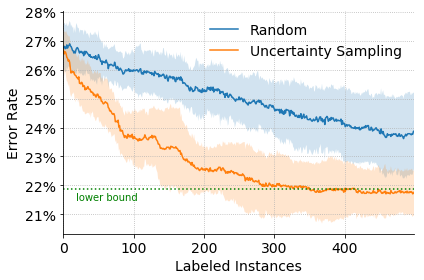

In [7]:
path = '../results/final_500/'
with open(path + 'random_results.json') as f:
    random = json.load(f)
with open(path + 'uncertainty_ENTROPY_results.json') as f:
    u_lc = json.load(f)

line_w_error({'Random': random, 'Uncertainty Sampling': u_lc}, name='us-vs-rnd',
            baselines={'lower bound': .2189})

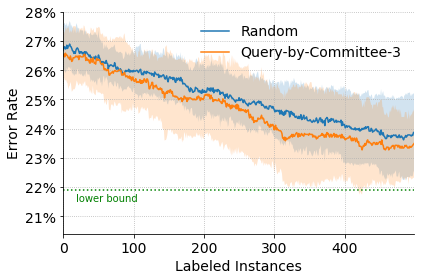

In [8]:
path = '../results/'
with open(path + 'final_500/random_results.json') as f:
    random = json.load(f)
with open(path + 'qbc_500/qbc_KL_results.json') as f:
    qbc = json.load(f)

line_w_error({'Random': random, 'Query-by-Committee-3': qbc}, name='qbc-vs-rnd',
            ylim=(.204, .28), baselines={'lower bound': .2189})

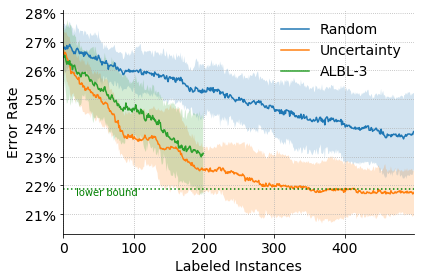

In [33]:
path = '../results/'
with open(path + 'final_500/random_results.json') as f:
    random = json.load(f)
with open(path + 'albl_200/albl_results.json') as f:
    albl = json.load(f)
with open(path + 'final_500/uncertainty_ENTROPY_results.json') as f:
    us = json.load(f)

line_w_error({'Random': random, 'Uncertainty': us, 'ALBL-3': albl}, name='albl-vs-rnd',
            baselines={'lower bound': .2189}, fill_na=True)

### US Version Comparison

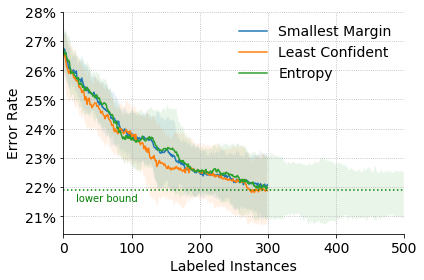

In [10]:
path = '../results/'
with open(path + 'us_SM_300/uncertainty_SM_results.json') as f:
    u_sm = json.load(f)
with open(path + 'us_LC_300/uncertainty_LC_results.json') as f:
    u_lc = json.load(f)
with open(path + 'final_500/uncertainty_ENTROPY_results.json') as f:
    u_ent = json.load(f)

line_w_error({'Smallest Margin': u_sm, 'Least Confident': u_lc, 'Entropy': u_ent},
             name='us_comparison', ylim=(.204, .28), xlim=(0,500), baselines={'lower bound': .2189}, alpha=.1)

## US C Comparison

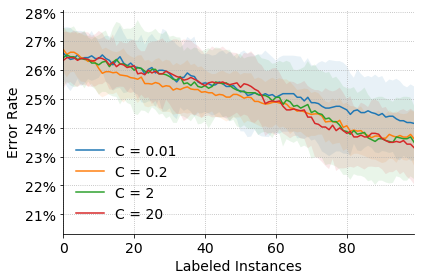

In [11]:
path = '../results/us_C_influence/'
with open(path + 'us_ENTROPY-C-0.01_results.json') as f:
    u_001 = json.load(f)
with open(path + 'us_ENTROPY-C-2_results.json') as f:
    u_2 = json.load(f)
with open(path + 'us_ENTROPY-C-20_results.json') as f:
    u_20 = json.load(f)
with open(path + '../final_500/uncertainty_ENTROPY_results.json') as f:
    u = json.load(f)

line_w_error({'C = 0.01': u_001, 'C = 0.2': u, 'C = 2': u_2, 'C = 20': u_20},
             name='us_C_comparison', alpha=.1)


## Small initial training base influence



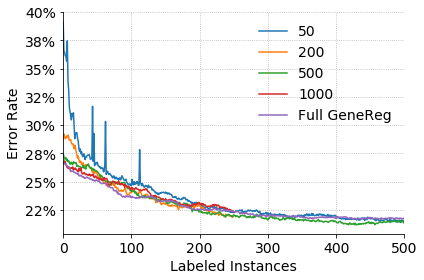

In [18]:
path = '../results/basesize_eval/'
with open(path + '../no_base/initial-1/us_ENTROPY_results.json') as f:
    b0 = json.load(f)
with open(path + 'basesize_50-resampled/us_ENTROPY_results.json') as f:
    b50 = json.load(f)
with open(path + 'basesize_200-resampled/us_ENTROPY_results.json') as f:
    b200 = json.load(f)
with open(path + 'basesize_500-resampled/us_ENTROPY_results.json') as f:
    b500 = json.load(f)
with open(path + 'basesize_1000-resampled/us_ENTROPY_results.json') as f:
    b1000 = json.load(f)
with open('../results/final_500/uncertainty_ENTROPY_results.json') as f:
    bfull = json.load(f)

line_w_error({
#     '0': b0,
    '50': b50,
    '200': b200,
    '500': b500,
    '1000': b1000,
    'Full GeneReg': bfull,
}, error=False, fill_na=True, xlim=(0, 500), ylim=(.204, .4), name='genereg_base_size_compare')

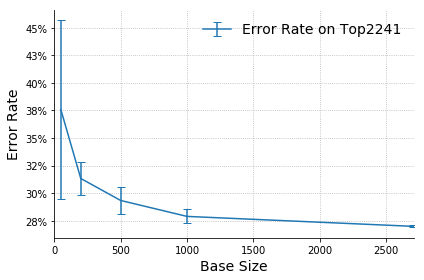

In [342]:
path = '../results/basesize_eval/'
with open(path + 'cc_50_results.json') as f:
    b50 = json.load(f)
with open(path + 'cc_200_results.json') as f:
    b200 = json.load(f)
with open(path + 'cc_500_results.json') as f:
    b500 = json.load(f)
with open(path + 'cc_1000_results.json') as f:
    b1000 = json.load(f)

b2703 = {'avg': .27, 'stdev': .001}

d = {'Error Rate on Top2241': [], 'stdev': []}
for i in [b50, b200, b500, b1000,b2703]:
    d['Error Rate on Top2241'].append(i['avg'])
    d['stdev'].append(i['stdev'])
df = pd.DataFrame(d, index=[50,200,500,1000,2703])
pl = df.plot(yerr='stdev', capsize=4, xlim=(0, 2710))


pl.set_xlabel('Base Size', fontsize=14)
format_err_ax(pl)
format_plot(pl)
pl.get_figure().savefig(os.path.join(output_path,'base-size_cc' + '_plot.pdf'), format='pdf')

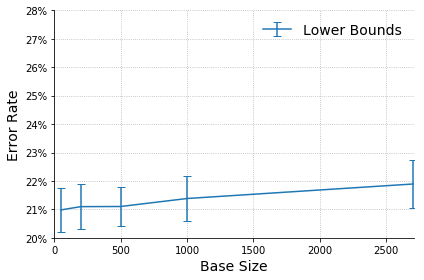

In [498]:
path = '../results/'
with open(path + 'lower_bound_50_results_100folds.json') as f:
    b50 = json.load(f)
with open(path + 'lower_bound_base-200_results.json') as f:
    b200 = json.load(f)
with open(path + 'lower_bound_base-500_results.json') as f:
    b500 = json.load(f)
with open(path + 'lower_bound_base-1000_results.json') as f:
    b1000 = json.load(f)
with open(path + 'lower_bound_results_100folds.json') as f:
    b2703 = json.load(f)

d = {'Lower Bounds': [], 'stdev': []}
for i in [b50, b200, b500, b1000, b2703]:
    d['Lower Bounds'].append(i['avg'])
    d['stdev'].append(i['stdev'])
df = pd.DataFrame(d, index=[50,200,500,1000,2703])
pl = df.plot(yerr='stdev', capsize=4, xlim=(0, 2710), ylim=(.20, .28))


pl.set_xlabel('Base Size', fontsize=14)
format_err_ax(pl)
format_plot(pl)
pl.get_figure().savefig(os.path.join(output_path,'lower_bounds' + '_plot.pdf'), format='pdf')


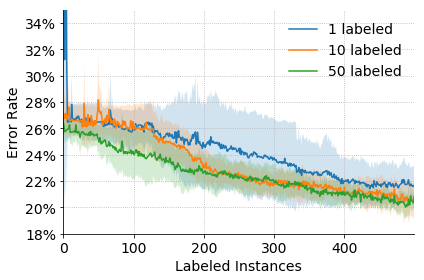

In [24]:
path = '../results/no_base/'
with open(path + 'initial-1/us_ENTROPY_results.json') as f:
    b1 = json.load(f)
with open(path + 'initial-10/us_ENTROPY_results.json') as f:
    b10 = json.load(f)
with open(path + 'initial-50/us_ENTROPY_results.json') as f:
    b50 = json.load(f)

line_w_error({
    '1 labeled': b1,
    '10 labeled': b10,
    '50 labeled': b50
}, error=True, fill_na=True,
    ylim=(.18,.35), name='no_base_compare')

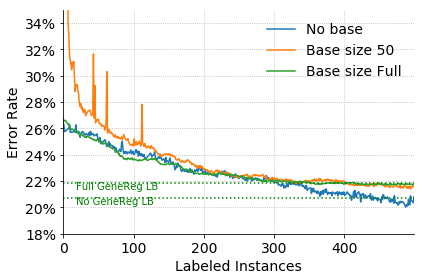

In [31]:
path = '../results/no_base/'
with open(path + '../basesize_eval/basesize_50-resampled/us_ENTROPY_results.json') as f:
    b50 = json.load(f)
with open(path + 'initial-1/us_ENTROPY_results.json') as f:
    nb1 = json.load(f)
with open(path + 'initial-10/us_ENTROPY_results.json') as f:
    nb10 = json.load(f)
with open(path + 'initial-50/us_ENTROPY_results.json') as f:
    nb50 = json.load(f)
with open('../results/final_500/uncertainty_ENTROPY_results.json') as f:
    bfull = json.load(f)

line_w_error({
    'No base': nb50,
    'Base size 50': b50,
    'Base size Full': bfull,
}, error=False, fill_na=True, baselines={'Full GeneReg LB':.2189, 'No GeneReg LB': 0.2073}, ylim=(.18,.35), name='base_vs_no_base_compare')

## Pool Size Influence

* full GeneReg, varying pool size => max achievable performance
* 20 repetitions

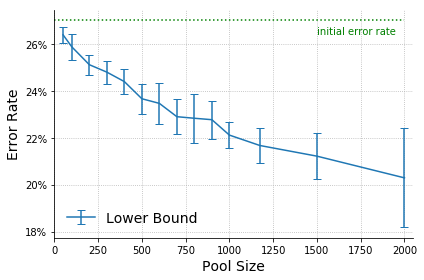

In [343]:
path = '../results/poolsize_eval/'
with open(path + 'full_genereg_poolsize-500_results.json') as f:
    p500 = json.load(f)
with open(path + 'full_genereg_poolsize-400_results.json') as f:
    p400 = json.load(f)
with open(path + 'full_genereg_poolsize-300_results.json') as f:
    p300 = json.load(f)
with open(path + 'full_genereg_poolsize-200_results.json') as f:
    p200 = json.load(f)
with open(path + 'full_genereg_poolsize-100_results.json') as f:
    p100 = json.load(f)
with open(path + 'full_genereg_poolsize-050_results.json') as f:
    p50 = json.load(f)
with open(path + 'full_genereg_poolsize-600_results.json') as f:
    p600 = json.load(f)
with open(path + 'full_genereg_poolsize-700_results.json') as f:
    p700 = json.load(f)
with open(path + 'full_genereg_poolsize-800_results.json') as f:
    p800 = json.load(f)
with open(path + 'full_genereg_poolsize-900_results.json') as f:
    p900 = json.load(f)
with open(path + 'full_genereg_poolsize-1000_results.json') as f:
    p1000 = json.load(f)
with open(path + 'full_genereg_poolsize-1500_results.json') as f:
    p1500 = json.load(f)
with open(path + 'full_genereg_poolsize-2000_results.json') as f:
    p2000 = json.load(f)
with open(path + '../lower_bound_results.json') as f:
    p1174 = json.load(f)
    
d = {'Lower Bound': [], 'stdev': []}
for i in [p50, p100, p200, p300, p400, p500, p600, p700, p800, p900, p1000, p1174, p1500, p2000]:
    d['Lower Bound'].append(i['avg'])
    d['stdev'].append(i['stdev'])
df = pd.DataFrame(d, index=[50,100,200,300,400,500,600,700,800,900,1000,1174, 1500, 2000])
pl = df.plot(yerr='stdev', capsize=4, xlim=(0,2050))

pl.plot([0,  2000], [.27, .27], color='g', linestyle=':')
pl.annotate('initial error rate', (1500, .264),  color='g')

pl.set_xlabel('Pool Size', fontsize=14)
format_err_ax(pl)
format_plot(pl)
pl.get_figure().savefig(os.path.join(output_path,'pool-size' + '_plot.pdf'), format='pdf')

## Expected Error Reduction Evaluation

* 3 folds
* subsample base 50
* 100 draws / 200 poolsize

{'avg': 0.2616364527192553,
 'max': 0.2709456148946594,
 'min': 0.25526702596766304,
 'stdev': 0.008242334072151166}

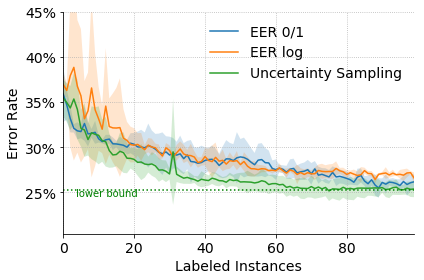

In [38]:
path = '../results/eer_eval/'
with open(path + 'us-random_200-pool_100-rounds/random_results.json') as f:
    random = json.load(f)
with open(path + 'us-random_200-pool_100-rounds/us_ENTROPY_results.json') as f:
    us = json.load(f)
with open(path + 'eer_200-pool_100-rounds/eer_log_results.json') as f:
    eer = json.load(f)
with open(path + 'eer_01_200-pool_100-rounds/eer_01_results.json') as f:
    eer01 = json.load(f)
    
line_w_error({'EER 0/1': eer01, 'EER log': eer, 'Uncertainty Sampling': us},
             name='eer_vs_rnd', baselines={'lower bound': 0.2527}, ylim=(.204, .45))

eer01['E_outs'][-1]

{'avg': 0.2702280537332084,
 'max': 0.2811621368322399,
 'min': 0.25679475164011256,
 'stdev': 0.01237444693554405}

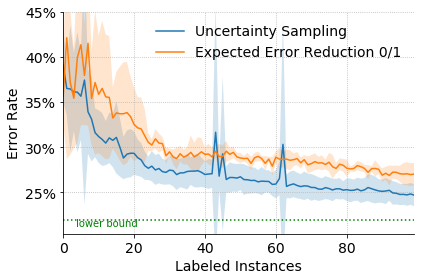

In [40]:
path = '../results/'
with open(path + 'basesize_eval/basesize_50-resampled/us_ENTROPY_results.json') as f:
    us = json.load(f)
with open(path + 'eer_eval/eer_1174subsample200-pool_100-rounds/eer_01_SMPL_results.json') as f:
    eer = json.load(f)

line_w_error({'Uncertainty Sampling': us, 'Expected Error Reduction 0/1': eer}, name='eer_SMPL-vs-rnd',
             baselines={'lower bound': .2189}, ylim=(.204, .45))
eer['E_outs'][-1]